<a href="https://colab.research.google.com/github/MuraliKrishnadata/google_colab_working_files/blob/main/sarima_Assinment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SARIMA forecast

## 01 - Background

Our goal in this challenge is to apply the basic concepts of time series analysis on one-dimension data (sales depending on the date).

In this challenge, we'll go through the following steps :
1. load and visualize the data;
2. train our models and make predictions;
3. use an econometric approach to model the serie and be able to forecast it;
4. use machine learning to hack this modelization.



## 02 - Load Data
Let's start by loading the time series of the challenge

In [ ]:
  import pandas as pd
  import numpy as np
  import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("/content/monthly_champagne_sales.csv")

In [ ]:
data.sample(10)

,Month,Sales
25,1966-02,3006
41,1967-06,4539
78,1970-07,4217
80,1970-09,5221
3,1964-04,2721
94,1971-11,9851
101,1972-06,5312
24,1966-01,3113
65,1969-06,4677
28,1966-05,3937


👉 Convert dataframe with datetime objects as index to make it look like this
![image.png](attachment:image.png)

In [ ]:
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

In [ ]:
data.sample(10)

,Sales
Month,
1970-05-01,2927
1965-02-01,2475
1972-07-01,4298
1965-05-01,3776
1971-08-01,1659
1967-04-01,4514
1969-03-01,4510
1967-01-01,5375
1964-11-01,5764


In [ ]:
data.rename(columns={'Month': 'Date'}, inplace=True)

In [ ]:
data.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [ ]:
data.drop('month', axis=1, inplace=True)

## 04 - Visualize and interpet the data

Well done, thanks to this "reindexing", you should now be able to plot the "Sales" (y-axis) as a function of the time (x-axis) easily

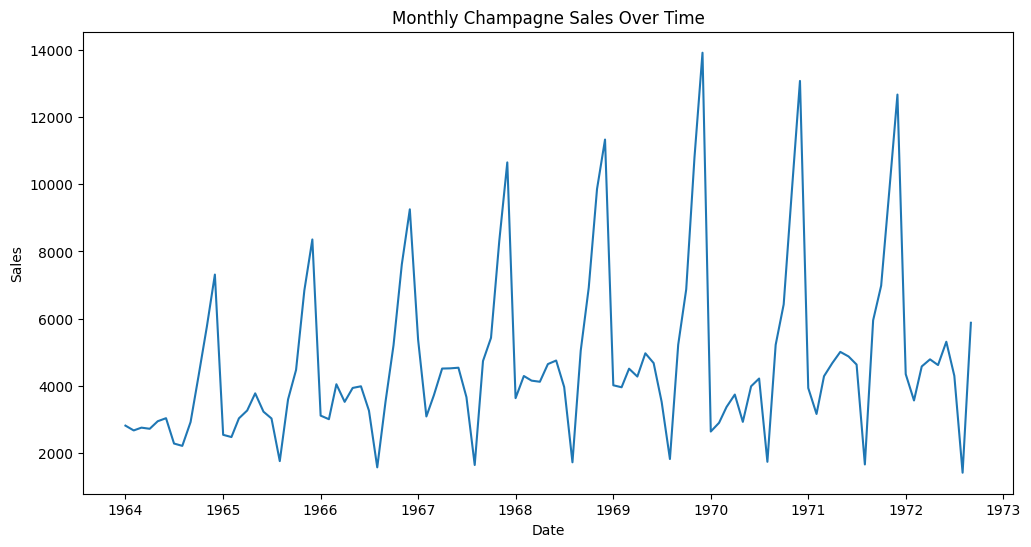

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Champagne Sales Over Time')
plt.show()

If your code is correct, you should be able to see that this Time Serie (TS) is:
- Not stationary (mean and variance are not constant).
- Exhibits strong seasonality.
- Seems to have a trend.

Let's see a decomposition of the data between **trend**, **saisonality** and **noise**. In order to do that, you have to make use of statsmodels [`seasonal_decompose`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html). Read the docs and make sure you understand what this function is doing and how to use it. Then:
1. plot the "Sales" with an "additive" model
2. plot the "Sales" with a "multiplicative" model

Pro tips: end your statsmodels plot method calls with a `;` to avoid double-plotting issues

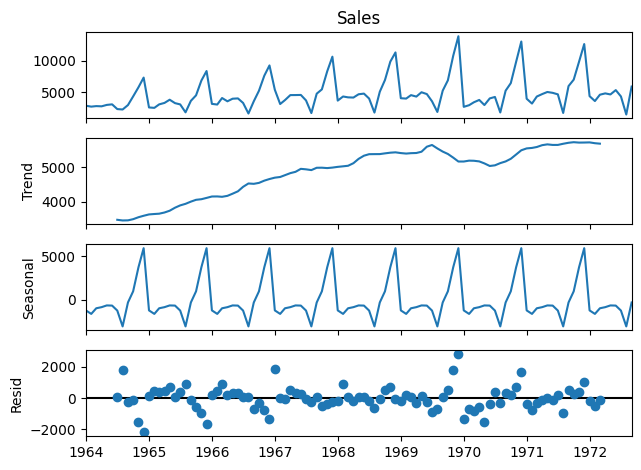

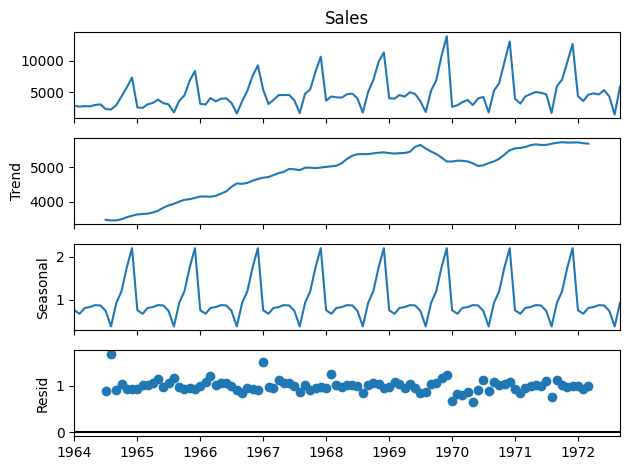

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive Decomposition
additive_decomposition = seasonal_decompose(data['Sales'], model='additive')
additive_decomposition.plot();

# Multiplicative Decomposition
multiplicative_decomposition = seasonal_decompose(data['Sales'], model='multiplicative')
multiplicative_decomposition.plot();

👉 De-seasonalize this time serie using the decomposition of your choice

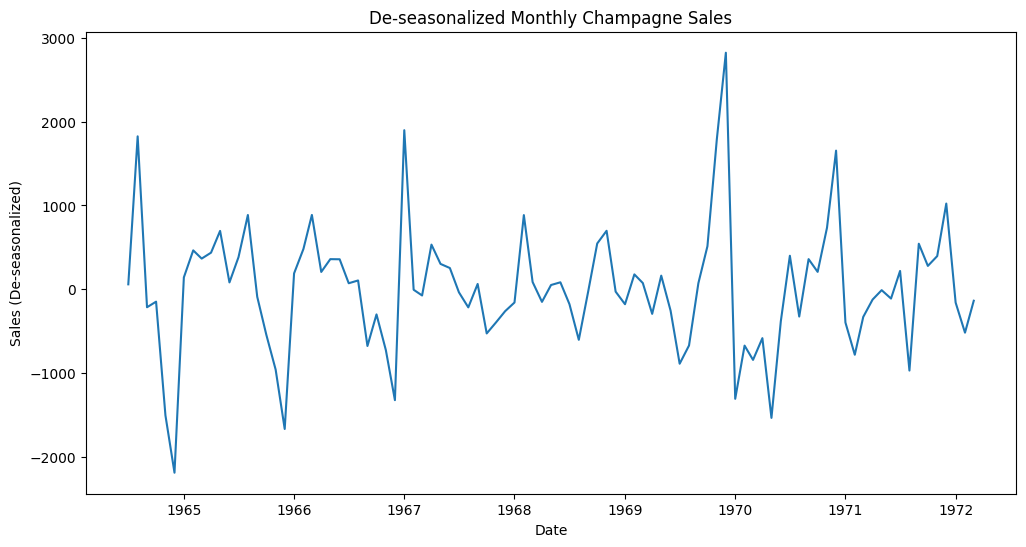

In [ ]:
# De-seasonalize the time series using the additive decomposition's residual
deseasonalized_data = additive_decomposition.resid.dropna()

# You can plot the de-seasonalized data to see the result
plt.figure(figsize=(12, 6))
plt.plot(deseasonalized_data)
plt.title('De-seasonalized Monthly Champagne Sales')
plt.xlabel('Date')
plt.ylabel('Sales (De-seasonalized)')
plt.show()

☝️ We could fit an ARIMA model on a "de-seasonalized" version of this time serie, and then re-compose it back after our forecast. But in this challenge, we will use SARIMA models to _directly_ fit the original time serie!

## 05 - Split the data (train/test)


For time series, we cannot randomly sample points to be in the test set. The test set needs to be "out-of-time", that is, strictly in the future of the test set. For the purpose of this exercise, we will use data up to 1970 for training and after for the test.

👉 create `df_train` and `df_test`, splitting the DataFrame before 1970 for the training and after (or equal to) for the testing

In [ ]:
df_train = data[data.index.year < 1970]
df_test = data[data.index.year >= 1970]

## 06 - SARIMA
We will analyse the data using a SARIMA model (Seasonal Auto Regressive Integrated Moving Average).


We need to :
- find how to stationarize the time serie (I in SARIMA)
- find the auto-regressive (AR) part
- find the Moving-Average (MA) part
- find the seasonality (S)

### Step 1: Check stationarity

If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast.

A quick glance at the plot above should be sufficient to convince you that the time serie is not stationary.

Double check the stationarity of `df["Sales"]` using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) and especially its p-value

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(data['Sales'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -1.8335930563276215
p-value: 0.36391577166024586


The p-value should be less than 0.05 to have a 95% confidence in the stationarity.  

If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

Ideally, p is *much* smaller than 0.05.

Another way to look for stationarity, is to look at the autocorrelation function (ACF).

Plot the ACF of the time series. You should see a large peak at lag 12, indicating strong yearly seasonality.

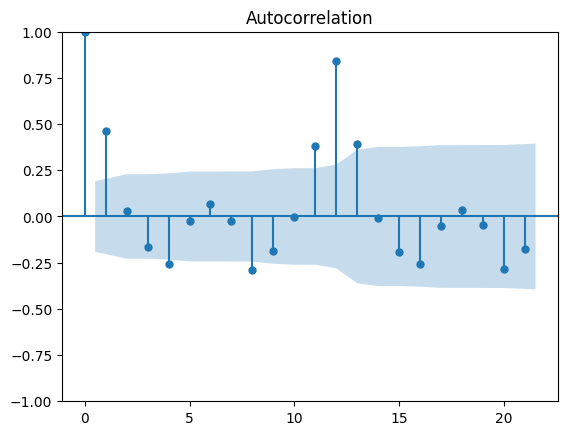

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data['Sales']);

### Step 2 - Seasonal differencing (D)

We have a strong seasonality with a period of 12 months.

Do a **seasonal differencing of lag 12** on the time series, and plot the differenced data and check the ACF plot (+ADF test) again.

Don't forget to drop NaN's.

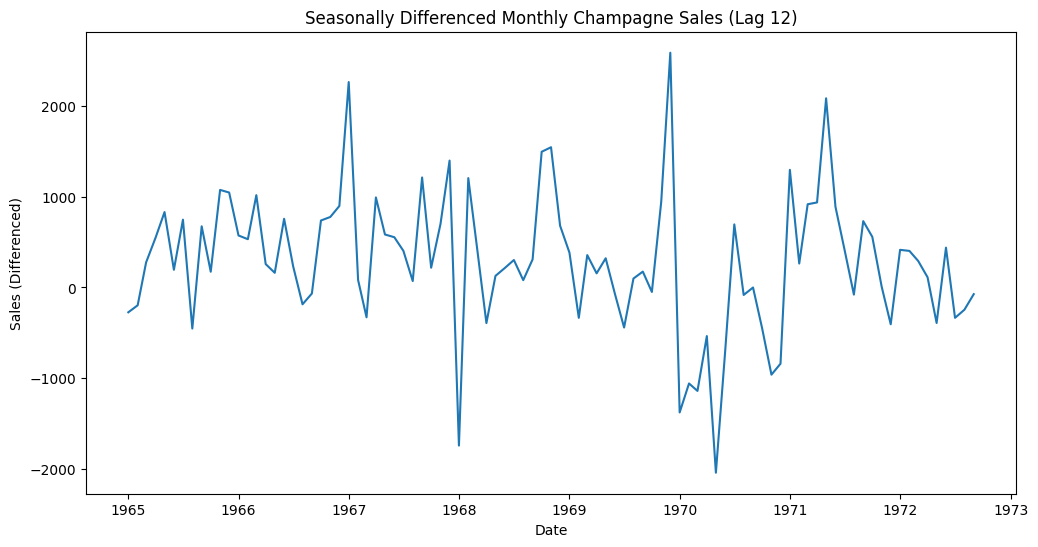

ADF Statistic (Seasonal Differencing): -7.626619157213166
p-value (Seasonal Differencing): 2.0605796968136632e-11


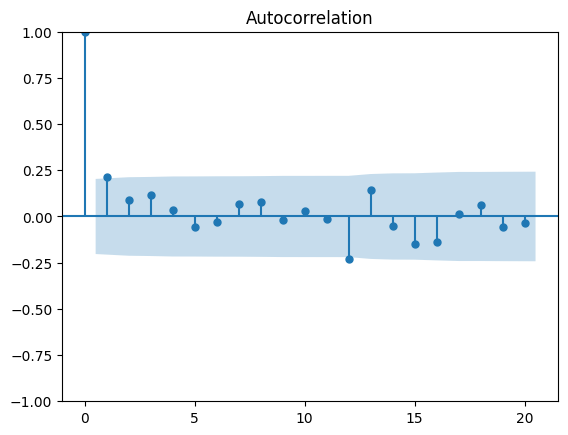

In [ ]:
# Seasonal differencing with lag 12
data_diff_12 = data['Sales'].diff(12).dropna()

# Plot the differenced data
plt.figure(figsize=(12, 6))
plt.plot(data_diff_12)
plt.title('Seasonally Differenced Monthly Champagne Sales (Lag 12)')
plt.xlabel('Date')
plt.ylabel('Sales (Differenced)')
plt.show()

# ADF test on differenced data
adf_result_diff_12 = adfuller(data_diff_12)
print(f'ADF Statistic (Seasonal Differencing): {adf_result_diff_12[0]}')
print(f'p-value (Seasonal Differencing): {adf_result_diff_12[1]}')

# Plot ACF of differenced data
plot_acf(data_diff_12);

☝️ One single seasonal differencing seems enough to stationarize the TS.  
D=1 (1 seasonal diff) and m=12 (seasonality = 12) for SARIMA(p,d,q, P,D,Q,m)

### Step 3 - Differencing (d)

If the time series is still not stationary, it needs to be stationarized through *differencing*. It means that we take the difference between each value and the preceding one (*first difference*).

Do we need further differencing after removing the seasonality?

Check the ACF and ADF after running an additional first order diff(1) on your diff(12) series.

ADF Statistic (Seasonal and First Differencing): -4.427713497307506
p-value (Seasonal and First Differencing): 0.0002650462849293455


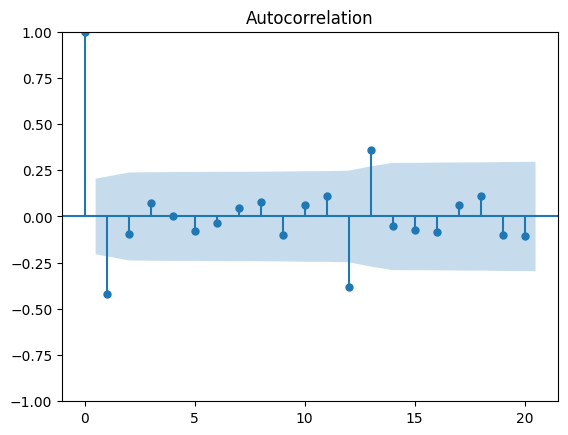

In [ ]:
# Apply first-order differencing to the seasonally differenced data
data_diff_12_1 = data_diff_12.diff(1).dropna()

# ADF test on the new differenced data
adf_result_diff_12_1 = adfuller(data_diff_12_1)
print(f'ADF Statistic (Seasonal and First Differencing): {adf_result_diff_12_1[0]}')
print(f'p-value (Seasonal and First Differencing): {adf_result_diff_12_1[1]}')

# Plot ACF of the new differenced data
plot_acf(data_diff_12_1);

👉 Additional differencing actually made both the p-value and the ACF look worse!
We can select (d=0) and (D=1)

### Step 4 - Select AR(p,P) and MA(q,Q) terms

You will now use the ACF and PACF plots to decide whether to include an AR term(s), MA term(s), or both.





- The autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to your **fully differentiated** series allows you to select MA number (`q`)
- MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d+D)}}$ cuts off


- The partial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to your **fully differentiated** series allows you to select AR (`p`)
- AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d+D)}}$  cuts off

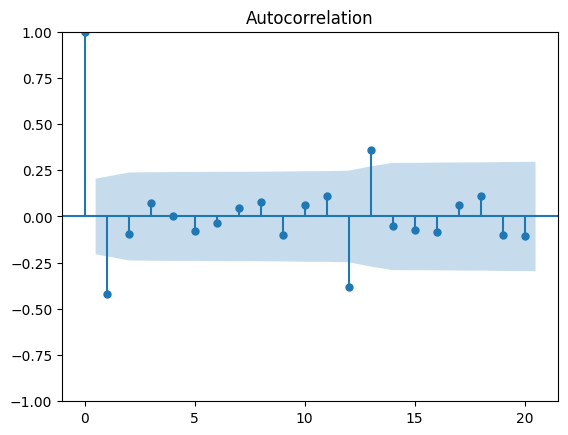

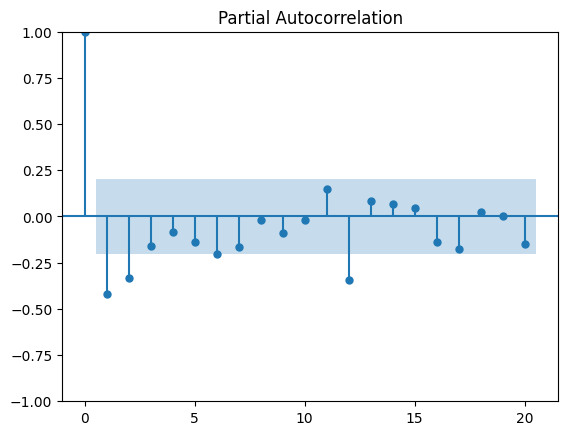

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

# Plot ACF of the fully differenced data
plot_acf(data_diff_12_1);

# Plot PACF of the fully differenced data
plot_pacf(data_diff_12_1);

☝️ It seems like there are no significant peaks in either ACF or PACF, so most likely p=q=0.  
Our first guess for SARIMA is therefore d=0, p=q=0, D=1 and m=12.  

How to find values for P and Q? Here, we will let pdarima try values 1 and 0 for P and Q with a grid_search for us.
If you really want to find these coefficient by yourself, [Read here 🤯 ](https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima) for some rules of thumb

👉 Run [auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) for the training set. set seasonal=True, m=12 and D=1. Search for p and q, P and Q from 0 to 2. Then, print the summary of the model with model.summary().
Use `njobs=-1, trace=True, error_action='ignore', suppress_warnings=True`

In [ ]:
!pip uninstall -y numpy pmdarima
!pip install numpy pmdarima
from pmdarima import auto_arima
!pip install numpy pmdarima

In [ ]:
!pip install pmdarima

In [ ]:
#!pip uninstall -y numpy pmdarima
#!pip install numpy==1.26.4 pmdarima==2.0.4
from pmdarima import auto_arima
model = auto_arima(df_train['Sales'], seasonal=True, m=12, D=1,
                   p=(0, 2), d=0, q=(0, 2),
                   P=(0, 2), Q=(0, 2),
                   njobs=-1, trace=True, error_action='ignore', suppress_warnings=True)

print(model.summary())

ModuleNotFoundError: No module named 'pmdarima'

The best model found is `ARIMA(0,0,0)(0,1,0)[12]` !
This means that the Time Serie condidered does not justify adding any "autoregressive" nor "moving average" modelling beyond simple "seasonal differencing".

Such "poor" model is only likely to predict a repetition of the last seasonal pattern detected, alongwith the prolongation of the mean increasing trend. Let's check it out

👉 Use `model.predict` with `n_periods` = length of the test set, in order to save the following three predictions
- `central`
- `upper`
- `lower`

Save them as Pandas Series, and index them by the same index than your `y_test`

In [ ]:
# Make predictions
forecast_results = model.predict(n_periods=len(df_test), return_conf_int=True)

# Extract central, lower, and upper predictions
central = pd.Series(forecast_results[0], index=df_test.index)
lower = pd.Series(forecast_results[1][:, 0], index=df_test.index)
upper = pd.Series(forecast_results[1][:, 1], index=df_test.index)

NameError: name 'model' is not defined

👇 Run the cell below to plot your predictions against reality

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label = "train values")
plt.plot(df_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index,
                 lower,
                 upper,
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

NameError: name 'plt' is not defined

👉 Try to assign non-null values to  `p`,`d`,`P`,`D` on your SARIMA and re-plot this chart to compare effects!

#  Machine Learning Approach

### Model with forecast horizon = 1 month only

We will now fit a non linear model such as a random forest. The idea is to predict a value from the last ones.

👉 Create new columns in `df` that are shifted version of `df['Sales']`. Do it with a shift from 1 to 12.

In [ ]:
# Add lagged values

# Drop nan


# create df_train and df_test


In [ ]:
# Keep track of test_indexes

In [ ]:
# Create X, y

👉 Instanciate (don't train) a `random forest` algorithm to predict Sales based in your shifted features

👉 You can use the following function to test it. It takes the true y values (`data` which should be a Numpy array), the indexes of the test samples (`test_indexes`), the predictor (`predictor`: your random forest algorithm) and the shifted columns (`full_X` which should be a Numpy array).

In [ ]:
# For each predictor, design a method to evaluate its performance on the test set:
from sklearn.metrics import r2_score
def evaluate_performance_month_prediction(y_true, test_indexes, predictor, full_X):
    predictions = []
    ground_truth = []
    i = 0
    for _indx in test_indexes:
        train_data = y_true[:_indx]
        current_ground_truth = y_true[_indx]
        current_ground_truth_features = full_X[_indx,:]
        train_features = full_X[:_indx]
        # train the model on all datapoint until (t-1) in order to predict (t)
        predictor.fit(train_features, train_data)
        prediction = predictor.predict(current_ground_truth_features.reshape(1,-1))[0]
        predictions.append(prediction)
        ground_truth.append(current_ground_truth)
        i += 1
    mape = np.mean(np.abs(np.array(predictions) - np.array(ground_truth))/np.abs(np.array(ground_truth)))
    return ground_truth, predictions, mape

In [ ]:
results = evaluate_performance_month_prediction(y.values, test_indexes=test_indexes,
                                                         predictor=random_forest, full_X = X.values)

In [ ]:
print('Mean Absolute Prediction Error MAPE')
results[2]

In [ ]:
plt.plot(results[0], c='black', label='test set')
plt.plot(results[1], c='orange', label='forecast (horizon = 1)')
plt.legend()

To improve our model, we can do some feature engineering. You will add moving averages to the data used to train the random forest.

Try to create 3 new columnns in `df`: one which is the rolling average of `df[Sales]` with a window of 12, one with a window of 3, and one with a window of 2. This will have the effect to isolate the trend and allow the algorithm to learn it. Also, plot these data.


In [ ]:
# Extract the trend using a well chosen moving average

You can also add a more smoothing predictor using the exponential moving average (hint: method `.ewm` with `halflife` of 2, 3 and 12), that statistically optimizes an AR process. Plot also the data.

You should see a better MAPE!

Try to look at the importance of each feature. What do you find?


### Out-of-sample forecast models

Let's now try to beat SARIMA in the "out-of-sample" prediction.

👉 Train _one model per horizon of forecast_ (from `1` month horizon to `len(y_test)` months)  
👉 Evaluate MAPE and compare with SARIMA